# Neural networks in Tensorflow

Seminar outline
- Why Neural Networks?
- Keras API
- TensorBoard

You may need to pip install in your environment the following packages: `tensorflow-addons`, `tqdm` 

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


print(tf.__version__)

2.7.0


## From linear models to neural networks

As we observed in the previous examples, feature selection and engineering can make or break your linear model. Although it seems easy on toy problems, such as the example below, finding good features becomes a highly non-trivial task when working with more complex data.
<img src="resources/features.png" width=600>

**Could we also automate feature engineering?**

Let's say we'll add another linear model just to perform feature selection and use the output of the first model as the input for predictions.
<img src="resources/linear_stack.png" width=600>

In this case, what would our prediction $\hat{y}$ look like?
$$ \hat{y} = w^T\tilde{x} = w^T(Wx) = (w^TW)x = w'^Tx$$

The matrix $W$ and vector $w$ just get multiplied, resulting in the linear coefficients vector $w'$. Most optimization algorithms would yeld the same values for $w$ and $w'$. Stacking two linear models together is just like having a single one.  Note that for our toy example above, the "good feature" was **not linear** with respect to the original ones. 

Then, let's try to add a non-linearity:

<img src="resources/nonlinear_stack.png" width=600>

where $g(x)$ is some **nonlinear scalar function** applied **element-wise**.

Now our prediction looks a bit different, the two sets of weights can not be merged into a single one anymore:
$$ \hat{y} = w^T\tilde{x} = w^Tg(Wx) $$

Congratulations! We just created a basic **neural network**. A more detailed representation of what we did would look like this:
<img src="resources/neural_network.png" width=600>

As the specific terminology goes, we have:
- **Neurons:** The values represented by $x_i$ or $\tilde{x}_i$. Also the output $\hat{y}$ is considered a neuron.
- **Layers:** The column of $x_i$ values is considered the *input layer*, $\tilde{x}_i$ are part of a *hidden layer* and the single $\hat{y}$ value is considered the *output layer*
- **Weights:** Usually denoted by $W_{ij}$ or $w_i$
- **Activation Function:** Our nonlinear scalar function $g$. Confusingly enough "the neuron's activation" (not activation function) is the value that gets computed inside that neuron (a.k.a the result of the application of the activation function)

### Activation functions

Any continuous and differentiable non-linear function should be fine for our activation, but if we take into account some pragmatic aspects such as the complexity of computation and the behavior of the derivative, there are a handful that used most of the time:
- $\text{sigmoid}(x)=\frac{1}{1+e^{-x}}$
- $\text{tanh}(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$
- $\text{ReLU}(x)=\mathrm{max}(0, x)$
  
Of course, there are others, but for now let's try and see what those three look like. They are already implemented can use the Tensorflow neural network submodule to access `tf.nn`

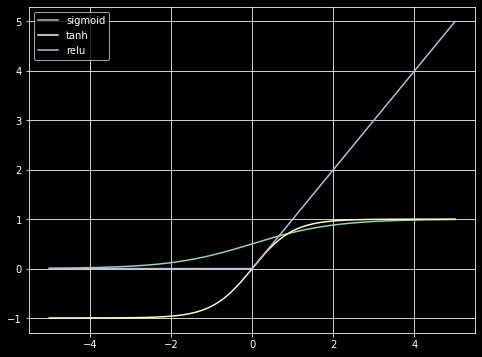

In [2]:
x = np.linspace(-5, 5, 1000)
sigmoid = tf.nn.sigmoid(x)
tanh = tf.nn.tanh(x)
relu = tf.nn.relu(x)

plt.figure(figsize=(8,6))
plt.grid()
plt.plot(x, sigmoid.numpy(), label="sigmoid")
plt.plot(x, tanh.numpy(), label="tanh")
plt.plot(x, relu.numpy(), label="relu")
plt.legend()
plt.show()

### So what is all this *deep learning* that I keep hearing about?

Mathematically speaking, this neural network with a single *hidden layer* is an **universal function approximator**. Since we could make the size of our hidden layer arbitrarily large, we could, in theory approximate any function with arbitrarily good precision. In weight matrix between two layers always has a dimension equal to $d \times d'$. So if we want, we could make the hidden layer have 1000 nodes (or neurons), but if our input has 10 nodes, we will arrive at 10000 parameters to optimize.

However, similar levels of performance could be expected if we just have 2 layers of 10 neurons each. This results in $10 \times 10 \times 2 = 200$ parameters to optimize. This is why, in practice is better to go deeper rather than wider. 
<img src="resources/deep_net.png" width=600>

## Hands-on example

Let's generate some toy data with a 2D function that has a binary output

In [3]:
@np.vectorize
def some_2d_function(x, y, noise=0):
    eps = np.random.normal(0,noise)
    y = y+0.4
    z = np.sin(7*x**2-eps)+np.cos(7*y**2+eps)+(x**2+y**2)-np.exp(x*y)
    return x**2 if x**2>(y) else z

@np.vectorize
def some_2d_function_binary(x, y, noise=0):
    z = some_2d_function(x, y, noise)
    return 0 if z > 0 else 1

In [4]:
u_low, u_high, u_step = -1, 1, 0.02
v_low, v_high, v_step = 0, 1, 0.01
u, v = np.meshgrid(np.arange(u_low, u_high, u_step), 
                     np.arange(v_low, v_high, v_step))
y = some_2d_function(u,v)
y_binary = some_2d_function_binary(u,v)

We end up with two categories of points distributed as seen below. The true categories as defined by the analytical function are separated by the contour, but our samples are a bit noisy (as real data usually is) so they may end up falling outside of the contour sometimes.

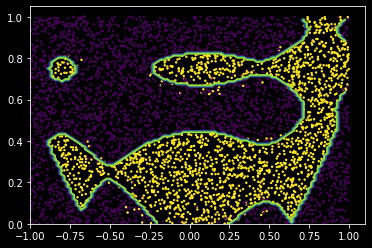

In [21]:
u_sample = np.random.uniform(u_low, u_high, 5_000)
v_sample = np.random.uniform(v_low, v_high, 5_000)
y_sample = some_2d_function_binary(u_sample, v_sample, noise=0.2)
fig = plt.figure()
plt.contour(u, v, y_binary)
plt.scatter(u_sample, v_sample, c=y_sample, s=2)
plt.show()

Now we just need to separate our training and testing data

In [22]:
X = np.vstack([u_sample, v_sample]).T
X_train, X_test, y_train, y_test = train_test_split(X, y_sample, test_size=0.2)
print(X_train.shape, y_train.shape)

(4000, 2) (4000,)


### Tensorflow keras API

We are going to use `keras` which is a **high-level API** for defining and training neural networks Tensorflow. Setting up the parameters, applying activation functions, differentiation and computing the gradients to update parameters are all handled under the hood by `keras` using **low-level** Tensorflow. In `kears` we work with higher level objects such as `Layers` and `Models`.

First let's define our model as a `tf.keras.Sequential()` object. Then we use the `add` method to set up the `Layers` which will be part of the model. There are several types of layers defined in `keras`, but for now we just need `Dense` and `Activation`, as we showed in the introductory explanation.

**Notes:**
- only the first layer needs an `input_shape` specification, the rest of them an considered to have the previous layer as input, by default
- the hidden layer has `relu` as the activation function, but for the output `sigmoid` is more convenient, since it returns values in the $(0, 1)$ interval, and our true labels are either 0 or 1
- the dense layer also has a constant term called *bias* $b$ for every neuron. Thus to compute the value of the $j$-th neuron on the layer $k$, before applying the activation function, we have:
  $$  x_j^{(k)} = (\sum_i^d W_{ij}x_i^{(k-1)}) + b_j $$
  where $d$ is the number of neurons in the layer $k-1$ and $W$ is the weight matrix between the two layers

In [23]:
tfkl = tf.keras.layers

classification_model = tf.keras.Sequential()
classification_model.add(
    tfkl.Dense(1000, input_shape=(2,),
                name="hidden_layer")
)
classification_model.add(
    tfkl.Activation(tf.nn.relu, 
                    name="hidden_activation")
)
classification_model.add(
    tfkl.Dense(1, name="output_layer")
)
classification_model.add(
    tfkl.Activation(tf.nn.sigmoid, 
                    name="output_activation")
)                     

With the model defined, we just need to *compile* it. This process will create the weights and biases parameters for all the layers and define the loss function, optimization strategy and (optionally) evaluation metrics

#### Binary Cross-entropy Loss
For binary classification tasks, the prediction error is way better represented by the **binary cross-entropy** than anything else.

$$ \mathcal{L}_\text{BCE}(y_\text{true}, y_\text{pred}) = -[(1-y_\text{true})\log(1-y_\text{pred}) + y_\text{true}\log(y_\text{pred})] $$

We basically treat our prediction of a probability of the data to belong to class `1`. 

In [25]:
classification_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), 
                             loss=tf.keras.losses.BinaryCrossentropy(),
                             metrics=tf.metrics.BinaryAccuracy(threshold=0.5)
                             )
classification_model.summary()     

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 1000)              3000      
                                                                 
 hidden_activation (Activati  (None, 1000)             0         
 on)                                                             
                                                                 
 output_layer (Dense)        (None, 1)                 1001      
                                                                 
 output_activation (Activati  (None, 1)                0         
 on)                                                             
                                                                 
Total params: 4,001
Trainable params: 4,001
Non-trainable params: 0
_________________________________________________________________


Looking at the generated **summary**, we see all the layers that we defined previously. We also see the number of parameters associated with each one. For example, our *hidden_layer* that takes the 2D data points as input has 1000 output neurons resulting in $2 \times 1000$ weights and $1000$ biases. The *output_layer* returns our scalar prediction using the previous 1000 neurons, thus we have $1\times1000 + 1$ parameters

### Training the neural network

As we have previously seen with `sklearn` models, the training loop is integrated in a method called `fit` which takes the training data as positional arguments. On top of that we may also specify the `batch_size`, which represents how many data points to use for a single optimization step. Usually we need way more optimization steps than we get by splitting our dataset in batches. So, in practice we will re-use the same data multiple times, until our model has converged. Those are called `epochs`. For each *epoch* we split the training dataset in batches and do `X_train.shape[0]/batch_size` optimization steps.

In [26]:
epochs = 100
batch_size = 200

# initialize tqdm callback for a progress bar
tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = classification_model.fit(X_train, y_train, 
                                    epochs=epochs, batch_size=batch_size,
                                    verbose=0,
                                    callbacks=[tqdm_callback])

Training: 100%|██████████ 100/100 ETA: 00:00s,  30.56epochs/s


### Model evaluation

We can take a look of how the **accuracy** and **loss** changed from one epoch to the next.

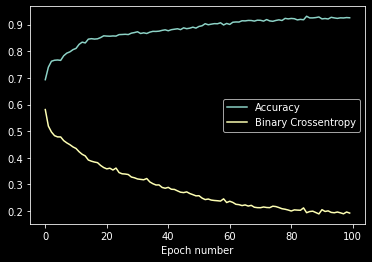

In [27]:
plt.figure()
plt.plot(np.arange(epochs), history.history["binary_accuracy"],
        label="Accuracy")
plt.plot(np.arange(epochs), history.history["loss"],
        label="Binary Crossentropy")
plt.legend()
plt.xlabel("Epoch number")
plt.show()

The `evaluate` method will compute the average loss on the given data alongside with any metrics that were defined in model compilation.

In [28]:
classification_model.evaluate(X_test, y_test)

32/32 [==============================] - 0s 658us/step - loss: 0.1953 - binary_accuracy: 0.9260


[0.19531723856925964, 0.9259999990463257]

Let's also take a look at our predictions on the test set by using the `predict` method. Are our predictions aligned with the true values? Are there regions in our input space where the model performs better?

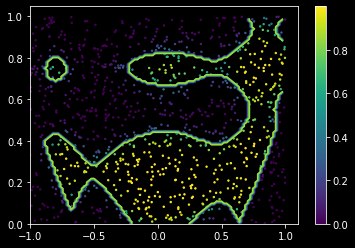

In [29]:
y_pred = classification_model.predict(X_test)
fig = plt.figure()
plt.contour(u, v, y_binary)
plt.scatter(X_test[:,0], X_test[:,1], c=y_pred, s=2)
plt.colorbar()
plt.show()

## Is deeper better than wider?
Write your own classification neural network with a number of total trainable parameters under $1000$ and an aim for an accuracy above $93\%$. You may change the previous model however you want. Add more layers, change the number of nodes, the loss function, batch size, optimizer, learning rate, it doesn't matter as long as long as you respect the size and accuracy conditions.

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 20)                60        
                                                                 
 hidden_activation1 (Activat  (None, 20)               0         
 ion)                                                            
                                                                 
 hidden_layer2 (Dense)       (None, 20)                420       
                                                                 
 hidden_activation2 (Activat  (None, 20)               0         
 ion)                                                            
                                                                 
 hidden_layer3 (Dense)       (None, 20)                420       
                                                                 
 hidden_activation3 (Activat  (None, 20)             

Training: 100%|██████████ 1000/1000 ETA: 00:00s,  62.02epochs/s


32/32 [==============================] - 0s 1ms/step - loss: 0.1275 - binary_accuracy: 0.9430


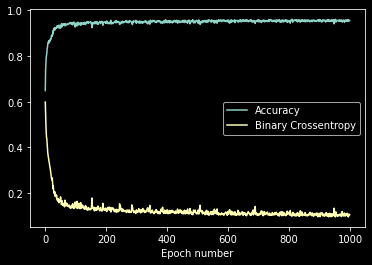

In [48]:
# your code here

deep_model = tf.keras.Sequential()
deep_model.add(
    tfkl.Input(2)
)
deep_model.add(
    tfkl.Dense(20, name='hidden_layer1')
)
deep_model.add(
    tfkl.Activation(tf.nn.relu, name='hidden_activation1')
)
deep_model.add(
    tfkl.Dense(20, name='hidden_layer2')
)
deep_model.add(
    tfkl.Activation(tf.nn.relu, name='hidden_activation2')
)
deep_model.add(
    tfkl.Dense(20, name='hidden_layer3')
)
deep_model.add(
    tfkl.Activation(tf.nn.relu, name='hidden_activation3')
)
deep_model.add(
    tfkl.Dense(1, name='output_layer')
)
deep_model.add(
    tfkl.Activation(tf.nn.sigmoid, name='output_activation')
)

deep_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

deep_model.summary()

epochs = 1000
batch_size = 200

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = deep_model.fit(X_train, y_train, 
                                    epochs=epochs, batch_size=batch_size,
                                    verbose=0,
                                    callbacks=[tqdm_callback])

deep_model.evaluate(X_test, y_test)

plt.figure()
plt.plot(np.arange(epochs), history.history["binary_accuracy"],
        label="Accuracy")
plt.plot(np.arange(epochs), history.history["loss"],
        label="Binary Crossentropy")
plt.legend()
plt.xlabel("Epoch number")
plt.show()

## Homework

Using what you learned so far, develop a machine learning model for regression on data generated by `some_2d_function`. This time we are trying to predict the actual function value instead of labeling the values with $1$ or $0$.

The code below will generate the data samples and split them into training and testing. Feel free to increase the sample size if you feel you may need it.

In [98]:
sample_size = 5_000
u_sample3d = np.random.uniform(u_low, u_high, sample_size)
v_sample3d = np.random.uniform(v_low, v_high, sample_size)
y_sample3d = some_2d_function(u_sample3d, v_sample3d, noise=0.2)
X = np.vstack([u_sample3d, v_sample3d]).T

X_train, X_test, y_train, y_test = train_test_split(X, y_sample3d, test_size=0.2)

3D plots of the true function values and our scattered nosy data points.

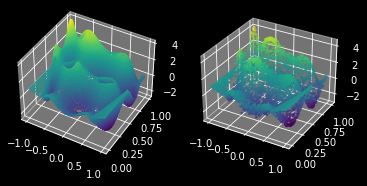

In [99]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax1.contour3D(u,v,y,100)
ax1.view_init(40, -60)
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(u_sample3d, v_sample3d, y_sample3d, s=2, c=y_sample3d)
plt.show()

#### Suggested steps:
- **Define the problem:** we know we have a regression to do, but how should we implement it? What would be an appropriate loss function? By which metrics should we evaluate our predictions?
- **Define and compile your own model:** How big are the layers? How deep should the network be? What will be our activation functions? What optimizer should we use for gradient descent? Learning rate value?
- **Train the model:** Chose the batch size and number of epochs and fit the model.
- **Evaluation plots:** Show how the model converged to minimum loss. Show relevant plots for your prediction results.

In [108]:
deep_model = tf.keras.Sequential()
deep_model.add(
    tfkl.Input(2)
)
deep_model.add(
    tfkl.Dense(15, name='hidden_layer1')
)
deep_model.add(
    tfkl.Activation(tf.nn.relu, name='hidden_activation1')
)
deep_model.add(
    tfkl.Dense(15, name='hidden_layer2')
)
deep_model.add(
    tfkl.Activation(tf.nn.relu, name='hidden_activation2')
)
deep_model.add(
    tfkl.Dense(15, name='hidden_layer3')
)
deep_model.add(
    tfkl.Activation(tf.nn.relu, name='hidden_activation3')
)
deep_model.add(
    tfkl.Dense(15, name='hidden_layer4')
)
deep_model.add(
    tfkl.Activation(tf.nn.relu, name='hidden_activation4')
)
deep_model.add(
    tfkl.Dense(1, name='output_layer')
)
# deep_model.add(
#     tfkl.Activation(tf.nn.tanh, name='output_activation')
# )

deep_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01),
                   loss=tf.keras.losses.mse,
                   metrics=tf.metrics.MeanSquaredError())

deep_model.summary()

epochs = 1000
batch_size = 150

tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)

history = deep_model.fit(X_train, y_train, 
                                    epochs=epochs, batch_size=batch_size,
                                    verbose=0,
                                    callbacks=[tqdm_callback])

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer1 (Dense)       (None, 15)                45        
                                                                 
 hidden_activation1 (Activat  (None, 15)               0         
 ion)                                                            
                                                                 
 hidden_layer2 (Dense)       (None, 15)                240       
                                                                 
 hidden_activation2 (Activat  (None, 15)               0         
 ion)                                                            
                                                                 
 hidden_layer3 (Dense)       (None, 15)                240       
                                                                 
 hidden_activation3 (Activat  (None, 15)             

Training: 100%|██████████ 1000/1000 ETA: 00:00s,  40.76epochs/s


32/32 [==============================] - 0s 695us/step - loss: 0.0552 - mean_squared_error: 0.0552


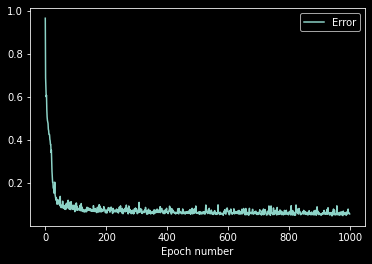

In [109]:
deep_model.evaluate(X_test, y_test)

plt.figure()
plt.plot(np.arange(epochs), history.history["mean_squared_error"],
        label="Error")
# plt.plot(np.arange(epochs), history.history["loss"],
#         label="Loss function")
plt.legend()
plt.xlabel("Epoch number")
plt.show()

## Homework 2

Now, let's take a look at a more complex example. We are going to use the **MNIST** dataset corresponding to hand written digits, represented as $28\times28$ matrices. The matrix values are brightness numbers in $[0, 255]$, you may want to rescale this into the $[0, 1]$ interval

<img src="resources/mnist.png" width=600>

Create a neural network that predicts the digit represented in the matrix. This is a multi-label classification problem.
 

Tips:
- Instead of trying to output a single value from `0` to `9`, which may be hard to interpret, try to have 10 output layers where the values are the probability of the input to correspond to each of 10 classes.
- You may do a one-hot encoding of your output to transform your training and test data (e.g. $2 \rightarrow [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$) and `CategoricalCrossentropy` would be your loss function.
- Alternatively, `SparseCategoricalCrossentropy` loss allows you to use the data output data as it is.
- For the output activation, `tf.nn.softmax` may be a good choice ([wiki link](https://en.wikipedia.org/wiki/Softmax_function)).
- You can't apply a `Dense` layer to a 2D Tensor. There is a special layer called `Flatten`, which reshapes a matrix into a single vector.

In [1]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

NameError: name 'tf' is not defined